<a href="https://colab.research.google.com/github/jingwoo4710/2020_project/blob/main/Week1_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr, spearmanr
import matplotlib.font_manager as fm
import matplotlib as mpl
import branca.colormap as cm
import folium
import geopandas as gpd


plt.style.use('default')
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=50).get_name()
print(font_name)
plt.rc('font', family=font_name)
fm._rebuild()

NanumGothic Eco


In [3]:
# COVID19 Data Import
corona_df = pd.read_csv('WHO-COVID-19-global-data.csv')

In [4]:
# Header 확인
corona_df.head(2)

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-03,AF,Afghanistan,EMRO,0,0,0,0
1,2020-01-04,AF,Afghanistan,EMRO,0,0,0,0


In [5]:
# header 공백 제거
cols = corona_df.columns.to_list()
corona_df.columns = [element.strip() for element in cols]
corona_df.head(2)

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths
0,2020-01-03,AF,Afghanistan,EMRO,0,0,0,0
1,2020-01-04,AF,Afghanistan,EMRO,0,0,0,0


In [6]:
# 국가별 총 확진자수
df_covid = corona_df.groupby(['Country', 'Country_code'])\
                    .sum()\
                    .rename_axis(['Country', 'Country_code'])\
                    .reset_index()
df_covid = df_covid.iloc[:,:3]
df_covid.columns = ['국가', '국가코드', '확진자 수']
df_covid.head()

,국가,국가코드,확진자 수
0,Afghanistan,AF,39422
1,Albania,AL,14410
2,Algeria,DZ,52270
3,American Samoa,AS,0
4,Andorra,AD,2370


In [7]:
# Big 5 성격테스트에서 Postive 와 Negative 문제 나누기 + 필요한 열 정의
pos_questions = [
    'OPN1','OPN3','OPN5','OPN7','OPN8','OPN9','OPN10',        # 7 개방성
    'CSN1','CSN3','CSN5','CSN7','CSN9','CSN10',               # 6 성실성
    'EXT1','EXT3','EXT5','EXT7','EXT9',                       # 5 외향성
    'AGR2','AGR4','AGR6','AGR8','AGR9','AGR10',               # 6 친화성
    'EST1','EST3','EST5','EST6','EST7','EST8','EST9','EST10', # 8 안정성(신경성)
]

neg_questions = [
    'OPN2','OPN4','OPN6',                # 3 개방성
    'CSN2','CSN4','CSN6','CSN8',         # 4 성실성
    'EXT2','EXT4','EXT6','EXT8','EXT10', # 5 외향성
    'AGR1','AGR3','AGR5','AGR7',         # 4 친화성
    'EST2','EST4',                       # 2 안정성(신경성)
]

use_cols = ['country'] + pos_questions + neg_questions 

In [8]:
# Big Five Personality Test Import 
trait = pd.read_csv('data-final.csv', sep = '\t', usecols=use_cols)

In [9]:
# 값이 0인 경우 NaN 처리 + 해당 row 삭제
trait = trait.replace(0,np.NaN).dropna(axis = 0).reset_index(drop = True)

In [10]:
# Country Name이 None 인 경우 삭제
i = trait.loc[trait.country == 'NONE'].index
trait.drop(i, inplace= True)

In [74]:
trait.loc[:,['EXT'+str(i) for i in range(1,11)]+['country']].head(5)

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,country
0,4.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,GB
1,3.0,5.0,3.0,4.0,3.0,3.0,2.0,5.0,1.0,5.0,MY
2,2.0,3.0,4.0,4.0,3.0,2.0,1.0,3.0,2.0,5.0,GB
3,2.0,2.0,2.0,3.0,4.0,2.0,2.0,4.0,1.0,4.0,GB
4,3.0,3.0,3.0,3.0,5.0,3.0,3.0,5.0,3.0,4.0,KE


In [72]:
['EXT'+str(i) for i in range(1,11)]

['EXT1',
 'EXT2',
 'EXT3',
 'EXT4',
 'EXT5',
 'EXT6',
 'EXT7',
 'EXT8',
 'EXT9',
 'EXT10']

In [12]:
# 데이터의 크기가 충분한 국가만 추출
train_countries = pd.DataFrame(data = trait.groupby('country')\
                                           .agg('size')\
                                           .loc[trait.groupby('country').agg('size') > 1000])

train_countries = train_countries.index.to_list()
print(train_countries)
len(train_countries)

['AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BR', 'CA', 'CH', 'CL', 'CN', 'CO', 'CZ', 'DE', 'DK', 'ES', 'FI', 'FR', 'GB', 'GR', 'HK', 'HR', 'HU', 'ID', 'IE', 'IL', 'IN', 'IT', 'JP', 'KE', 'KR', 'MX', 'MY', 'NL', 'NO', 'NZ', 'PE', 'PH', 'PK', 'PL', 'PT', 'RO', 'RS', 'RU', 'SE', 'SG', 'TH', 'TR', 'US', 'VN', 'ZA']


51

In [13]:
# train 데이터와 test 데이터 
train = trait.loc[trait.country.isin(train_countries)].reset_index(drop = True)
test = trait.loc[~trait.country.isin(train_countries)].reset_index(drop = True)

In [14]:
# train 국가 수 확인
print(len(train['country'].unique()))

51


In [15]:
# test 국가 수 확인
print(len(test['country'].unique()))

171


In [16]:
train.head(2)

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,EST1,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,EST10,AGR1,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,AGR10,CSN1,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,CSN10,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,country
0,4.0,1.0,5.0,2.0,5.0,1.0,5.0,2.0,4.0,1.0,1.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,2.0,5.0,2.0,4.0,2.0,3.0,2.0,4.0,3.0,4.0,3.0,4.0,3.0,2.0,2.0,4.0,4.0,2.0,4.0,4.0,5.0,1.0,4.0,1.0,4.0,1.0,5.0,3.0,4.0,5.0,GB
1,3.0,5.0,3.0,4.0,3.0,3.0,2.0,5.0,1.0,5.0,2.0,3.0,4.0,1.0,3.0,1.0,2.0,1.0,3.0,1.0,1.0,4.0,1.0,5.0,1.0,5.0,3.0,4.0,5.0,3.0,3.0,2.0,5.0,3.0,3.0,1.0,3.0,3.0,5.0,3.0,1.0,2.0,4.0,2.0,3.0,1.0,4.0,2.0,5.0,3.0,MY


In [17]:
test.head(2)

,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,EST1,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,EST10,AGR1,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,AGR10,CSN1,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,CSN10,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,country
0,3.0,3.0,2.0,3.0,3.0,2.0,4.0,3.0,3.0,5.0,4.0,3.0,4.0,1.0,2.0,3.0,5.0,4.0,4.0,5.0,2.0,5.0,3.0,4.0,2.0,3.0,1.0,3.0,4.0,2.0,1.0,5.0,5.0,5.0,1.0,5.0,3.0,1.0,1.0,5.0,5.0,1.0,5.0,1.0,5.0,1.0,5.0,5.0,5.0,5.0,UA
1,2.0,1.0,3.0,3.0,5.0,2.0,4.0,5.0,5.0,3.0,5.0,1.0,5.0,1.0,5.0,5.0,1.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,2.0,4.0,1.0,4.0,4.0,5.0,1.0,1.0,5.0,5.0,1.0,5.0,5.0,5.0,1.0,1.0,2.0,5.0,5.0,5.0,1.0,2.0,4.0,2.0,4.0,3.0,OM


In [18]:
# test 데이터 또한 샘플이 최소 500개는 가지도록 
test_countries = test.groupby('country').size()\
                     .loc[test.groupby('country').size() > 500]\
                     .index.to_list()

test = test.loc[test.country.isin(test_countries)]
print(len(test.country.unique()))

16


In [19]:
# 평균 계산을 위해 negative question 점수 scale 바꾸기
train[neg_questions] = train[neg_questions].apply(lambda x: 6 - x)
test[neg_questions] = test[neg_questions].apply(lambda x: 6 - x)

In [20]:
df_train = train.copy()
df_test = test.copy()

In [21]:
# Fucntion 
def summing_axis (df):
  traits = ['OPN','CSN','EXT','AGR','EST']
  for trait in traits:
    df[trait] = df[[col for col in df.columns if trait in col]].sum(axis = 1)
  return df[traits+['country']]
  

In [22]:
df_train = summing_axis(df_train)
df_test = summing_axis(df_test)

In [24]:
print(len(df_train.country.unique()))

51


In [25]:
print(len(df_test.country.unique()))

16


In [26]:
df_test.head(2)

,OPN,CSN,EXT,AGR,EST,country
0,50.0,24.0,29.0,37.0,39.0,UA
4,32.0,28.0,36.0,41.0,19.0,NG


In [27]:
# 나라별로 train data mean 구하기
mean_train = df_train.groupby('country').mean().rename_axis('country').reset_index()
mean_train.columns = ['국가코드', '개방성', '성실성', '외향성', '우호성', '안정성']
mean_train.head()

,국가코드,개방성,성실성,외향성,우호성,안정성
0,AE,37.639791,34.032090,30.261933,37.917770,31.475732
1,AR,40.133075,31.678530,28.345068,36.416248,32.381431
2,AT,40.836251,32.518538,29.899588,36.876931,29.856334
3,AU,38.551472,33.626061,29.937915,37.918328,30.393272
4,BE,39.308450,32.029262,29.967453,37.661989,30.598089


In [28]:
print(len(mean_train['국가코드'].unique()))

51


In [29]:
# 나라별로 test data mean 구하기
mean_test = df_test.groupby('country').mean().rename_axis('country').reset_index()
mean_test.columns = ['국가코드', '개방성', '성실성', '외향성', '우호성', '안정성']
mean_test.head()

,국가코드,개방성,성실성,외향성,우호성,안정성
0,CR,39.633028,32.664220,28.759633,35.908257,31.051376
1,EC,38.383138,31.910352,29.119530,35.337247,31.806830
2,EE,38.964045,32.362921,28.283146,35.783146,30.279775
3,EG,37.943890,33.007481,28.480050,36.966334,33.011222
4,IS,39.057728,32.614525,30.225326,37.696462,30.463687


In [30]:
print(len(mean_test['국가코드'].unique()))

16


In [31]:
# train 데이터 필터링
train_covid = df_covid.loc[df_covid['국가코드'].isin(train_countries)].reset_index(drop = True)
train_covid.head()

,국가,국가코드,확진자 수
0,Argentina,AR,798486
1,Australia,AU,27149
2,Austria,AT,49886
3,Belgium,BE,132109
4,Brazil,BR,4915289


In [32]:
print(len(train_covid['국가'].unique()))

50


In [33]:
# 빅 파이브 성격테스트와 COVID19 데이터 합치기
df_train = train_covid.merge(mean_train, on = '국가코드')
df_train.head()

,국가,국가코드,확진자 수,개방성,성실성,외향성,우호성,안정성
0,Argentina,AR,798486,40.133075,31.678530,28.345068,36.416248,32.381431
1,Australia,AU,27149,38.551472,33.626061,29.937915,37.918328,30.393272
2,Austria,AT,49886,40.836251,32.518538,29.899588,36.876931,29.856334
3,Belgium,BE,132109,39.308450,32.029262,29.967453,37.661989,30.598089
4,Brazil,BR,4915289,40.536946,31.240467,26.505017,34.946725,31.545703


In [34]:
len(df_train)

50

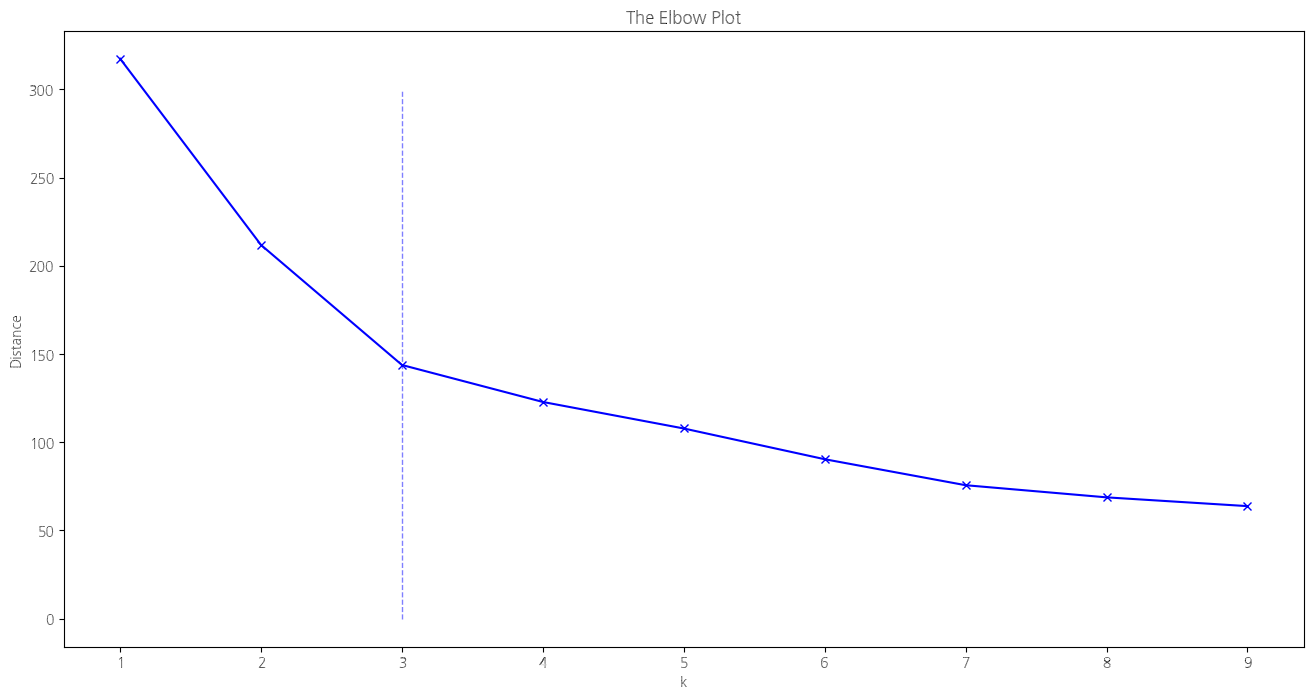

In [35]:
# elbow plot
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_train.iloc[:,3:8])
    distortions.append(kmeanModel.inertia_)
   

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distance')
plt.title('The Elbow Plot')
plt.vlines(x=3, ymin=0, ymax=300, alpha=0.5, color='blue', linestyle='dashed', linewidth=1.0)
plt.show()

In [36]:
# k에 따른 분포 비교

for k in range(2,5):
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_train.iloc[:,3:8])
    df_train['군집'] = kmeanModel.labels_
    print('k = ', k)
    print(df_train['군집'].value_counts(),'\n')

k =  2
0    26
1    24
Name: 군집, dtype: int64 

k =  3
1    22
2    16
0    12
Name: 군집, dtype: int64 

k =  4
0    22
2    13
1     9
3     6
Name: 군집, dtype: int64 



In [37]:
#k = 2로 설정
kmeans = KMeans(n_clusters=2)
kmeans.fit(df_train.iloc[:,3:8])
df_train['군집'] = kmeans.labels_
df_train.head()

,국가,국가코드,확진자 수,개방성,성실성,외향성,우호성,안정성,군집
0,Argentina,AR,798486,40.133075,31.678530,28.345068,36.416248,32.381431,1
1,Australia,AU,27149,38.551472,33.626061,29.937915,37.918328,30.393272,0
2,Austria,AT,49886,40.836251,32.518538,29.899588,36.876931,29.856334,0
3,Belgium,BE,132109,39.308450,32.029262,29.967453,37.661989,30.598089,0
4,Brazil,BR,4915289,40.536946,31.240467,26.505017,34.946725,31.545703,1


In [38]:
# label별 case 확인
print('군집 0의 수 : ', len(df_train.loc[df_train['군집'] == 0]))
print('군집 1의 수 : ', len(df_train.loc[df_train['군집'] == 1]))

군집 0의 수 :  26
군집 1의 수 :  24


In [39]:
# 결과가 좋지 않음 지나치게 outlier 인 미국과 인도를 빼자
i = df_train.loc[(df_train['국가'] == 'India') | (df_train['국가'] == 'United States of America')].index
df_train.drop(i, inplace=True)

In [40]:
# Label 별로 그룹
traits = ['개방성','성실성','외향성','우호성','안정성']

train_res = df_train.iloc[:, 2:]\
                    .groupby('군집')\
                    .mean()\
                    .rename_axis('군집')\
                    .reset_index()
train_res = train_res.apply(lambda x: x.round(2))
train_res = train_res.sort_values('확진자 수', ascending=False).reset_index(drop=True)
train_res

,군집,확진자 수,개방성,성실성,외향성,우호성,안정성
0,1,512379.08,39.65,32.13,28.48,35.84,31.62
1,0,168060.58,38.62,33.39,29.80,37.43,30.49


In [41]:
# test 나라들의 데이터 예측
mean_test['군집'] = kmeans.predict(mean_test.iloc[:,1:])
mean_test.head()

,국가코드,개방성,성실성,외향성,우호성,안정성,군집
0,CR,39.633028,32.664220,28.759633,35.908257,31.051376,1
1,EC,38.383138,31.910352,29.119530,35.337247,31.806830,1
2,EE,38.964045,32.362921,28.283146,35.783146,30.279775,1
3,EG,37.943890,33.007481,28.480050,36.966334,33.011222,1
4,IS,39.057728,32.614525,30.225326,37.696462,30.463687,0


In [42]:
df_test.head(2)

,OPN,CSN,EXT,AGR,EST,country
0,50.0,24.0,29.0,37.0,39.0,UA
4,32.0,28.0,36.0,41.0,19.0,NG


In [43]:
# Label 별로 그룹
df_test = mean_test.merge(df_covid, on = '국가코드')


test_res = df_test.loc[:, ['군집', '확진자 수'] + traits]\
                    .groupby('군집')\
                    .mean()\
                    .rename_axis('군집')\
                    .reset_index()
test_res = test_res.apply(lambda x: x.round(2))
test_res = test_res.sort_values('확진자 수', ascending=False).reset_index(drop=True)
test_res

,군집,확진자 수,개방성,성실성,외향성,우호성,안정성
0,1,100305.4,39.24,32.40,28.40,35.64,31.53
1,0,32628.0,38.57,34.19,29.64,37.93,30.71


In [44]:
train_res.iloc[0,1]/train_res.iloc[1,1]

3.04877610204606

In [45]:
test_res.iloc[0,1]/test_res.iloc[1,1]

3.074212332965551

In [46]:
# Plot

In [47]:
final_df = pd.concat([train_res, test_res], axis = 0)

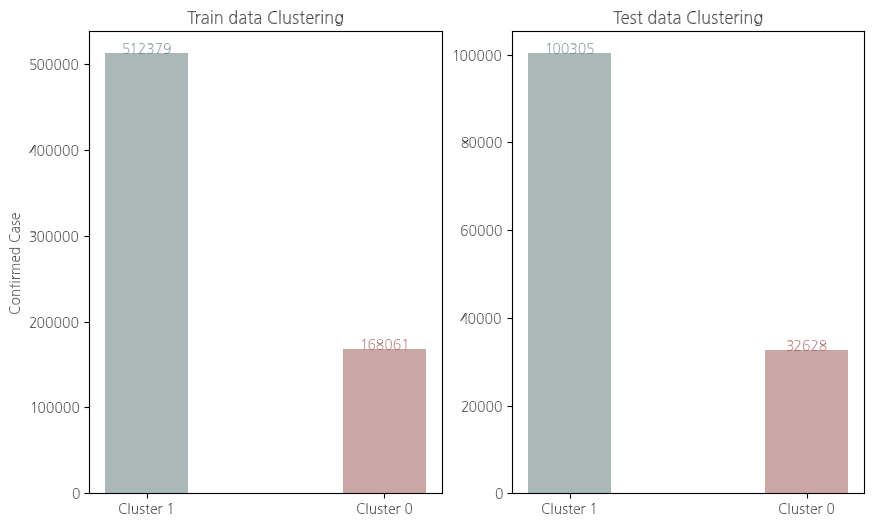

In [49]:
fig, axes = plt.subplots(1,2, figsize=(10, 6))

bar_width = 0.35

alpha = 0.5

index = np.arange(2)

y1 = train_res['확진자 수']

y2 = test_res['확진자 수']

p1 = axes[0].bar(index, y1, 

             bar_width, 

             color=['#567572FF', '#964F4CFF'],

             alpha=alpha,

             label='Train')
axes[0].set_xticks(index)
axes[0].set_xticklabels(['Cluster 1', 'Cluster 0'])
axes[0].set_ylabel('Confirmed Case')

axes[0].set_title('Train data Clustering')

p2 = axes[1].bar(index, y2, 

             bar_width, 

             color=['#567572FF', '#964F4CFF'], 

             alpha=alpha,

             label='Test')


axes[1].set_xticks(index)
axes[1].set_xticklabels(['Cluster 1', 'Cluster 0'])

axes[0].annotate(str(int(round(y1[0], 0))), xy=(0, y1[0]), fontsize=10, ha='center', color = '#567572FF') 
axes[0].annotate(str(int(round(y1[1], 0))), xy=(1, y1[1]), fontsize=10, ha='center', color = '#964F4CFF') 
axes[1].annotate(str(int(round(y2[0], 0))), xy=(0, y2[0]), fontsize=10, ha='center', color = '#567572FF') 
axes[1].annotate(str(int(round(y2[1], 0))), xy=(1, y2[1]), fontsize=10, ha='center', color = '#964F4CFF') 

plt.title('Test data Clustering')

plt.show()


